In [329]:
import pickle
import os

FOLDER = os.getcwd() + "/1_pt_blurry"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [330]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from SyMBac.PSF import PSF_generator


In [331]:
print(out)

[[    0 12482 22044 28515 31781 31781 28515 22044 12482     0]
 [12482 25270 35066 41695 45040 45040 41695 35066 25270 12482]
 [22044 35066 45040 51790 55195 55195 51790 45040 35066 22044]
 [28515 41695 51790 58621 62067 62067 58621 51790 41695 28515]
 [31781 45040 55195 62067 65535 65535 62067 55195 45040 31781]
 [31781 45040 55195 62067 65535 65535 62067 55195 45040 31781]
 [28515 41695 51790 58621 62067 62067 58621 51790 41695 28515]
 [22044 35066 45040 51790 55195 55195 51790 45040 35066 22044]
 [12482 25270 35066 41695 45040 45040 41695 35066 25270 12482]
 [    0 12482 22044 28515 31781 31781 28515 22044 12482     0]]


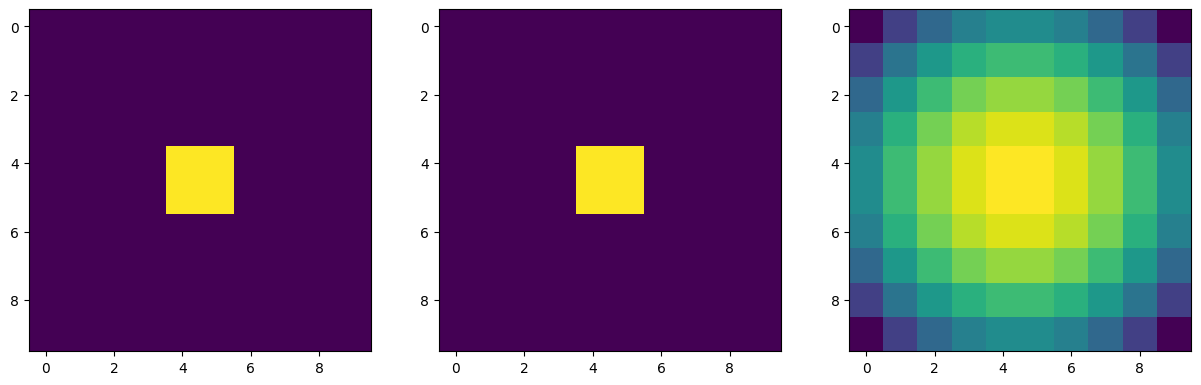

In [332]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

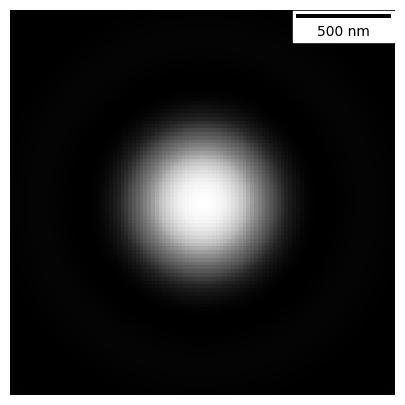

[[0.00414948 0.00415171 0.00409537 ... 0.00409537 0.00415171 0.00414948]
 [0.00415171 0.00409358 0.00397612 ... 0.00397612 0.00409358 0.00415171]
 [0.00409537 0.00397612 0.00379854 ... 0.00379854 0.00397612 0.00409537]
 ...
 [0.00409537 0.00397612 0.00379854 ... 0.00379854 0.00397612 0.00409537]
 [0.00415171 0.00409358 0.00397612 ... 0.00397612 0.00409358 0.00415171]
 [0.00414948 0.00415171 0.00409537 ... 0.00409537 0.00415171 0.00414948]]


/home/boomalope/symbac/symbac/lib/python3.8/site-packages/SyMBac/PSF.py:178: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


In [333]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.0, 
    n = 1.4, 
    resize_amount = 1, 
    pix_mic_conv = 0.02, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()
psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)
print(psf)

In [334]:
#Get all sourcePts
#Final all non zero mask points

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

print(sourcePts)

4
[[4, 4], [5, 5], [5, 4], [4, 5]]


In [335]:
def AverageFilter(img, x, y):
    sz = [ -2, -1, 0 , 1, 2]
    total = 0
    for i in sz:
        for j in sz:
            if x+i >= 0 and x+i < len(img) and y+j >= 0 and y+j < len(img[0]):
                total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

def getPSF(origin,target,psf):
    assert(len(psf)%2 == 1) and (len(psf[0])%2 == 1)
    centre = [int(len(psf)/2),int(len(psf[0])/2)]
    shifted_target = [target[0]-origin[0]+centre[0],target[1]-origin[1]+centre[1]]
    if (shifted_target[0] < 0 or shifted_target[0] >= len(psf)) or (shifted_target[1] < 0 or shifted_target[1] >= len(psf[0])):
        return 0
    else:
        return psf[shifted_target[0]][shifted_target[1]]

In [336]:
#Assemble the matrix

additionalPts = []
for _ in range(10):
    x = random.randint(0,len(out)-1)
    y = random.randint(0,len(out[0])-1)
    additionalPts.append([x,y])

b = []
for (x,y) in sourcePts:
    b.append(AverageFilter(out,x,y))
for (x,y) in additionalPts:
    b.append(AverageFilter(out,x,y))
b = np.array(b)
b = b/(2**16-1)

A = []

for x in sourcePts:
    a = []
    for y in sourcePts:
        a.append(getPSF(y,x,psf))
    A.append(a)
for x in additionalPts:
    a = []
    for y in sourcePts:
        a.append(getPSF(y,x,psf))
    A.append(a)
A = np.array(A)

#Solve the matrix
x_bar = np.linalg.lstsq(A, b)
print(x_bar)

b_ori = []
for (x,y) in sourcePts:
    b_ori.append(ori[x][y])
b_ori = np.array(b_ori)
print(b_ori)

(array([ 11257153.9985927 ,  10908835.35777748, -11035144.45317683,
       -11089554.37481391]), array([2.70215662e+09]), 4, array([7.13897377e+00, 7.38405701e-02, 5.12499742e-02, 4.24351570e-04]))
[1. 1. 1. 1.]


/tmp/ipykernel_357111/3705008256.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_bar = np.linalg.lstsq(A, b)


In [337]:
print(A,b)

[[1.         0.99285972 0.99642453 0.99642453]
 [0.99285972 1.         0.99642453 0.99642453]
 [0.99642453 0.99642453 1.         0.99285972]
 [0.99642453 0.99642453 0.99285972 1.        ]
 [0.91043318 0.94405663 0.91375007 0.94064852]
 [0.95434264 0.95434264 0.97169318 0.93725065]
 [0.91043318 0.94405663 0.94064852 0.91375007]
 [0.99285972 0.98576196 0.98222896 0.99642453]
 [0.91375007 0.91375007 0.89074113 0.93725065]
 [0.94064852 0.90054246 0.91043318 0.93048552]
 [0.96820223 0.94064852 0.94405663 0.96472173]
 [0.91375007 0.91375007 0.93725065 0.89074113]
 [0.91375007 0.94064852 0.94405663 0.91043318]
 [0.91375007 0.95434264 0.93725065 0.93048552]] [58645.6  58645.6  58645.6  58645.6  24407.28 38632.64 24407.28 55260.4
 20484.6  22440.   36133.92 20484.6  24407.28 28247.92]


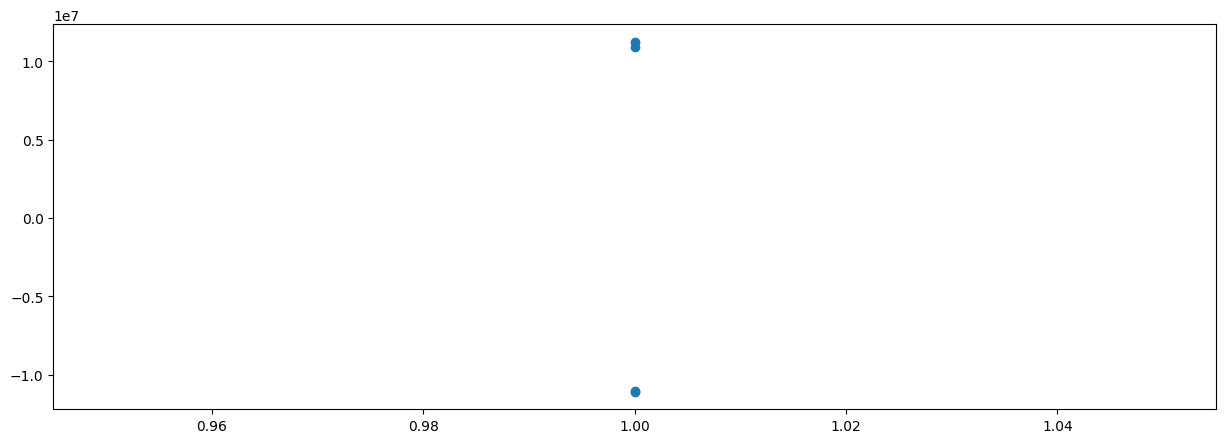

In [338]:
#Plot the result
plt.scatter(b_ori, x_bar[0])